In [1]:
from sogym.env import sogym
from sogym.utils import FigureRecorderCallback
import numpy as np
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3 import PPO
%load_ext autoreload
%autoreload 2
print('SB3 vestsion:', stable_baselines3.__version__)

/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SB3 vestsion: 1.7.0


---
### Environment test and visualization:

In [2]:
from stable_baselines3.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
check_env(sogym(nelx=100,nely=50,mode='train',observation_type='image'))

In [8]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(nelx=100,nely=50,mode='train',observation_type='image')
eval_env = sogym(nelx=100,nely=50,mode='test',observation_type='image')

In [9]:
# The training environment and the eval environment both have a different boundary conditions distribution:
print("Number of unique BC + desired volume frac combinations in the train distribution: ",len(train_env.BC_dict))
print("Number of unique BC + desired volume frac combinations in the test distribution: ",len(eval_env.BC_dict))

Number of unique BC + desired volume frac combinations in the train distribution:  4284
Number of unique BC + desired volume frac combinations in the test distribution:  2412


Volume:  0.44548527573609137
Reward  0.006185297854436147


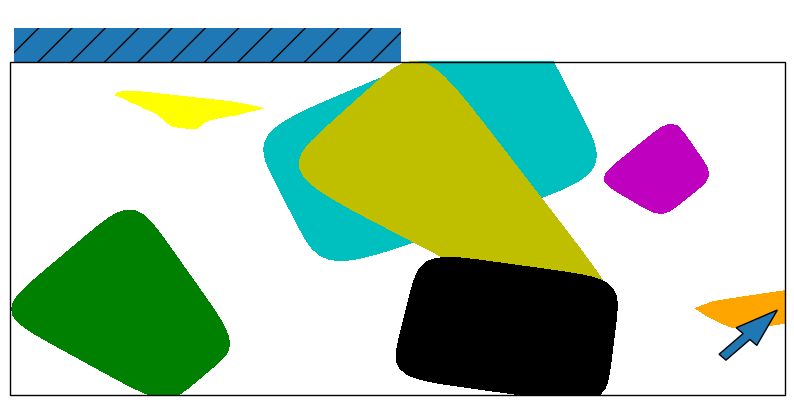

In [10]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward<1e-3:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, info = train_env.step(action)
print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

In [51]:
action

array([ 0.9842446 ,  0.4033344 ,  0.9965016 ,  0.5472497 ,  0.50237495,
       -0.04930849], dtype=float32)

In [68]:
train_env.compliance

161.67370165059046

Volume:  0.5892205829313992
Reward  0.0


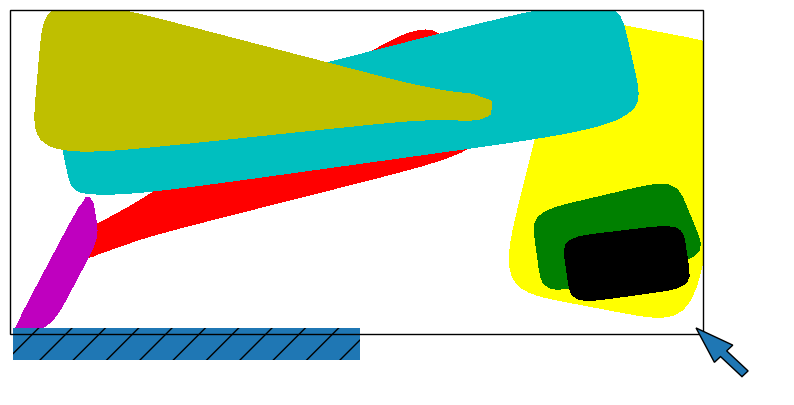

In [67]:
action = train_env.action_space.sample()
obs, reward, done, info = train_env.step(action)
print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot(train_viz=False)

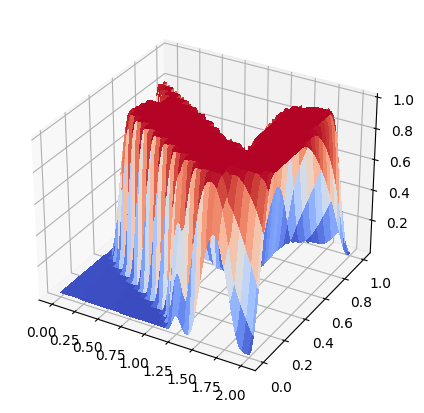

In [61]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

#surf = ax.plot_surface(train_env.x, train_env.y, train_env.Phi[:,5].reshape((train_env.nely+1,train_env.nelx+1),order='F'), cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

    
surf = ax.plot_surface(train_env.x, train_env.y, train_env.H.reshape((train_env.nely+1,train_env.nelx+1),order='F'), cmap=cm.coolwarm,
                     linewidth=0, antialiased=False)
# Make data.
#train_env.Phi

(5151,)

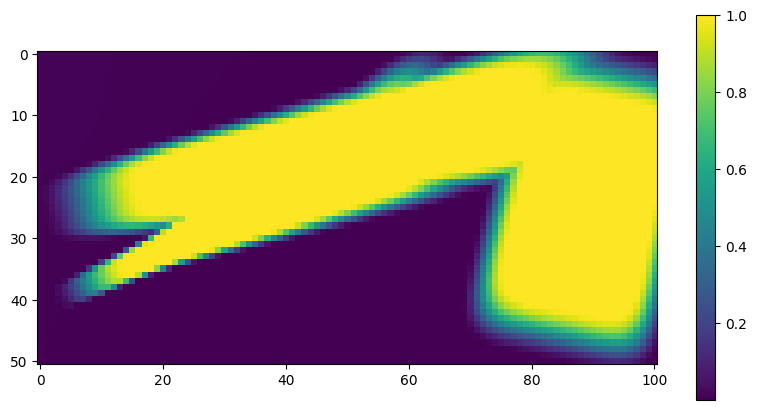

In [62]:
plt.imshow(train_env.H.reshape((train_env.nely+1,train_env.nelx+1),order='F'))
plt.colorbar()

Volume:  0.4979757553332994
Reward  0.0


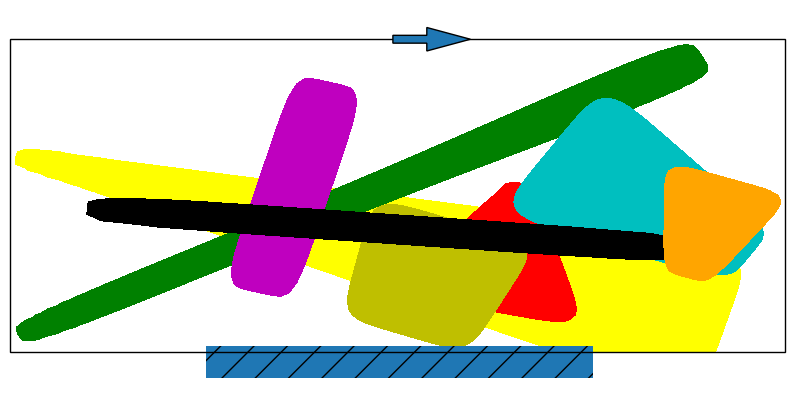

In [13]:
# Let's visualize the eval environment:
obs = eval_env.reset()
done = False
while not done:
    action = eval_env.action_space.sample()
    obs, reward, done, info = eval_env.step(action)
print("Volume: ", eval_env.volume)
print("Reward ",reward)
eval_env.plot()

---
### Multiprocessing

In [90]:
num_cpu = 32 # Number of processes to use
train_env = sogym(mode='train',observation_type='image')
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type='image')
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
eval_env =VecNormalize(eval_env,gamma=1.0)


In [91]:
# Let's  test that an eval callback actually works:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList

eval_callback = EvalCallback(eval_env,log_path='tb_logs',eval_freq=100,deterministic=True,render=False)
callback = CallbackList([eval_callback,
                         FigureRecorderCallback(check_freq=2*8*32)])

--- 
### Defining the model

In [93]:
import gym
import torch as th
from torch import nn

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict):
        # We do not know features-dim here before going over all the items,
        # so put something dummy for now. PyTorch requires calling
        # nn.Module.__init__ before adding modules

        super(CustomCombinedExtractor, self).__init__(observation_space, features_dim=1)
        self.drop_rate = 0.4
        self.activ_func = nn.ReLU()
        extractors = {}

        total_concat_size = 0
        # We need to know size of the output of this extractor,
        # so go over all the spaces and compute output feature sizes
        for key, subspace in observation_space.spaces.items():
            
            if key =='image':
                n_input_channels = subspace.shape[0]
                extractors[key]= nn.Sequential(
                                                nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=2, padding=1), #Out is 32 x 62 x 30
                                                nn.ReLU(),
                                                #nn.Dropout(p=self.drop_rate),
                                                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), #Out is 64 x 31 x 15
                                                nn.ReLU(),
                                                #nn.Dropout(p=self.drop_rate),
                                                nn.Flatten(),
                                            )
                total_concat_size+= 29760

            
            elif key == "design_variables" or key=="volume" or key=="n_steps_left":
                extractors[key] = nn.Sequential(
                                                #nn.Linear(subspace.shape[0], 128),
                                                #self.activ_func,
                                                #nn.Dropout(p=self.drop_rate),
                                                #nn.Linear(128,128),
                                                #self.activ_func,
                                                #nn.Dropout(p=self.drop_rate),
                                                nn.Flatten()
                                               )
                #total_concat_size += (128)
                total_concat_size+=(subspace.shape[0])

            
            elif key == "conditions" :
                # Run through a simple MLP
                extractors[key] = nn.Sequential(
                                                nn.Linear(subspace.shape[0], 128),
                                                self.activ_func,
                                                #nn.Dropout(p=self.drop_rate),
                                                nn.Linear(128,128),
                                                self.activ_func,
                                                #nn.Dropout(p=self.drop_rate),
                                                nn.Flatten()
                                               )
                total_concat_size += (128)
                #total_concat_size+=(subspace.shape[0])
                
           
           
          
         
        self.extractors = nn.ModuleDict(extractors)

        # Update the features dim manually
        self._features_dim = total_concat_size

    def forward(self, observations) -> th.Tensor:
        encoded_tensor_list = []

        # self.extractors contain nn.Modules that do all the processing.
        for key, extractor in self.extractors.items():
            encoded_tensor_list.append(extractor(observations[key]))
        # Return a (B, self._features_dim) PyTorch tensor, where B is batch dimension.
        return th.cat(encoded_tensor_list, dim=1)
    
policy_kwargs = dict(
    features_extractor_class=CustomCombinedExtractor,
    net_arch=[dict(pi=[512,512,512], vf=[512,512,512])],
               optimizer_kwargs={"weight_decay": 1e-3},
    
)

In [95]:
model = PPO("MultiInputPolicy",
            env,
            seed=42,
            policy_kwargs = policy_kwargs,
            n_steps=(2048*16)//32,  #def: 224
            batch_size=2048*2,#2048*2, #def: 50*224
            verbose=0,
            n_epochs=3,
            vf_coef = 1.0,
            clip_range = 0.3,
            clip_range_vf = 10.0,
            target_kl = 0.02,
            gamma=1.0,  #def: 1
            learning_rate=3e-4,
            ent_coef=3e-4,
            tensorboard_log="tb_logs",
            device='cuda')


/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/stable_baselines3/common/policies.py:458: UserWarning: As shared layers in the mlp_extractor are deprecated and will be removed in SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


--- 
### Training

In [ ]:
model.learn(50000000,callback=callback,tb_log_name='PPO_test_5M_l2_1e2')
model.save('model_saved',)
env.save('env_saved.pkl')

Eval num_timesteps=3200, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
New best mean reward!
Eval num_timesteps=6400, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
New best mean reward!
Eval num_timesteps=9600, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
Eval num_timesteps=12800, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
New best mean reward!
Eval num_timesteps=16000, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
Eval num_timesteps=19200, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
New best mean reward!
Eval num_timesteps=22400, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
Eval num_timesteps=25600, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
Eval num_timesteps=28800, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
Eval num_timesteps=32000, episode_reward=0.00 +/- 0.00
Episode length: 8.00 +/- 0.00
Eval num_timesteps=35200, episode_reward=0.00 +/- 0.00
Episode le

In [ ]:
num_cpu = 32 # Number of processes to use
train_env = sogym(mode='train',observation_type='image')
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecNormalize.load('env_saved.pkl',env)

eval_env = sogym(mode='test',observation_type='image')
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
eval_env = VecNormalize.load('env_saved.pkl',eval_env)

model.load('model_saved',env=env,device='cuda')
model.learn(500000,callback=callback,reset_num_timesteps=False,tb_log_name='PPO_test_1M')
model.save('model_saved_1M',)
env.save('env_saved_1M.pkl')

---
### Let's visualize the agent's performance:

In [86]:
env=sogym(mode='test',observation_type='image')
env = make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env = VecNormalize.load('env_saved.pkl',env)
env.training=False
env.norm_reward=False
model=model.load('model_saved')
#model.set_env(env)

[[ 1.       -1.        1.        0.918471 -1.       -1.      ]]
[[ 1.        1.        0.575478  1.       -1.       -1.      ]]
[[ 1.          1.          0.87357366  1.         -1.         -1.        ]]
[[ 0.48454762  1.          1.          1.         -1.         -1.        ]]
[[-0.42715895  1.          1.          1.         -1.         -1.        ]]
[[-1.          0.719636    1.          0.69414175 -1.         -1.        ]]
[[-1. -1.  1.  1. -1. -1.]]
[[-1. -1. -1.  1. -1. -1.]]
Reward: 0.0032587978837553887


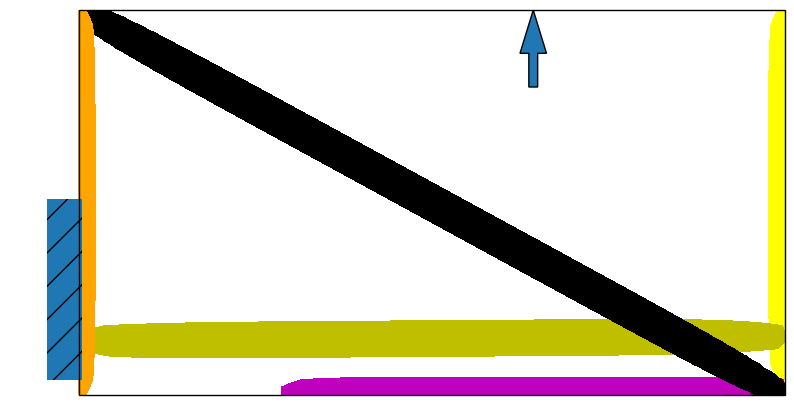

In [87]:
obs=env.reset()
dones=False

while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones, info = env.step(action)
  
print("Reward:",rewards[0])
#print("Volume:",np.round(env.get_attr('volume')[0]*100,2),"%")
fig=env.env_method('plot')[0]
#fig = env.render()

fig

In [88]:
1/rewards

array([306.86162066])

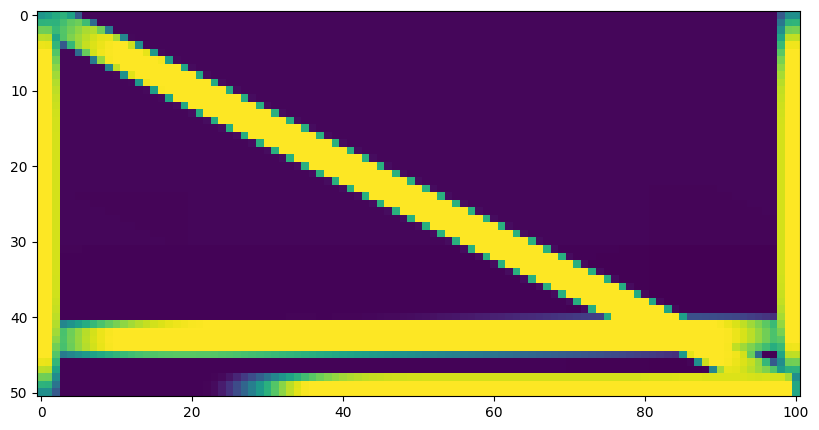

In [89]:
import matplotlib.pyplot as plt
plt.imshow(env.get_attr('H')[0].reshape((51,101),order='F'))